In [7]:
import os
import math
import numpy as np
import h5py
import glob
from tqdm import tqdm
import scipy

import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Embedding, Input, merge, ELU
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils.np_utils import to_categorical
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
plt.ion()

%matplotlib inline

Using Theano backend.


In [8]:
dfiles = glob.glob('/Users/davidleifer/Desktop/DanDoesData/self-driving/data/*.h5')

In [9]:
speedmax = None
speedmin = None
accelmax = None
accelmin = None
for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        # raw data
        A = dict(h5f.items()) 
        smx = np.max(A['vehicle_states'].value[:,2])
        smn = np.min(A['vehicle_states'].value[:,2])
        amx = np.max(A['vehicle_states'].value[:,3])
        amn = np.min(A['vehicle_states'].value[:,3])
        if speedmax is None or smx > speedmax:
            speedmax = smx
        if speedmin is None or smn < speedmin:
            speedmin = smn
        if accelmax is None or amx > accelmax:
            accelmax = amx
        if accelmin is None or amn < accelmin:
            accelmin = amn
        #plt.plot(A['targets'].value[:,3],A['targets'].value[:,5],'.')

In [10]:
# steering is nominally -1 to 1, but doesn't go below zero?
throttlemax = None
throttlemin = None
steermax = None
steermin = None
for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        # raw data
        A = dict(h5f.items()) 
        smx = np.max(A['targets'].value[:,4])
        smn = np.min(A['targets'].value[:,4])
        tmx = np.max(A['targets'].value[:,5])
        tmn = np.min(A['targets'].value[:,5])
        if steermax is None or smx > steermax:
            steermax = smx
        if steermin is None or smn < steermin:
            steermin = smn
        if throttlemax is None or tmx > throttlemax:
            throttlemax = tmx
        if throttlemin is None or tmn < throttlemin:
            throttlemin = tmn

In [11]:
def make_cat(gas_val):
    # drive forward
    if gas_val > 0.6:
        cat = 0
    # brake
    elif gas_val <= 0.6 and gas_val > 0.4:
        cat = 1
    # reverse
    else:
        cat = 2
    return cat

In [12]:
ndata = 0
imgsize = 64
# frame size
nrows = 64
ncols = 64

# speed, accel, distance, angle
real_in = Input(shape=(2,), name='real_input')

# video frame in, grayscale
frame_in = Input(shape=(3,nrows,ncols))

In [13]:
# convolution for image input
conv1 = Convolution2D(8,5,5,border_mode='same')
conv_l1 = conv1(frame_in)
Econv_l1 = ELU()(conv_l1)
pool_l1 = MaxPooling2D(pool_size=(2,2))(Econv_l1)

conv2 = Convolution2D(8,5,5,border_mode='same')
conv_l2 = conv2(pool_l1)
Econv_l2 = ELU()(conv_l2)
pool_l2 = MaxPooling2D(pool_size=(2,2))(Econv_l2)

flat = Flatten()(pool_l2)

M = merge([flat,real_in], mode='concat', concat_axis=1)

D1 = Dense(64)(M)
ED1 = ELU()(D1)
D2 = Dense(32)(ED1)
ED2 = ELU()(D2)
D3 = Dense(32)(ED2)
ED3 = ELU()(D3)

A1 = Dense(32)(ED3)
EA1 = ELU()(A1)
#S1 = Dense(32)(ED3)
#ES1 = ELU()(S1)

# Turn off bias because so much time is spent going forward
Accel = Dense(3, activation='sigmoid', bias=False)(EA1)
#Steer = Dense(1, activation='linear')(ES1)

model = Model(input=[real_in, frame_in], output=[Accel])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        # raw data
        A = dict(h5f.items()) 
        # extract images in 1-byte format
        B = np.array(A['images'].value,dtype=np.float16)/255.
        # change BGR to RGB
        B = B[:,::-1,:,:]
        # Scale down image size
        imgs = np.zeros((len(B),3,64,64),dtype=np.float16)
        for i,b in enumerate(B):
            imgs[i] = scipy.misc.imresize(b,(64,64),'cubic','RGB').transpose((2,0,1))
        # speed and accel scale
        speedx = A['vehicle_states'].value[:,2:4]
        speedx[:,0] = (speedx[:,0] - speedmin) / (speedmax-speedmin)
        speedx[:,1] = (speedx[:,1] - accelmin) / (accelmax-accelmin)
        # throttle and steering scale
        targets_cat = list(map(make_cat, (A['targets'].value[:,5] + 1) / 2.))
        targets = to_categorical(targets_cat,3)
        # Train while we have this file open
        h = model.fit([speedx, imgs], [targets],
                batch_size = 32, nb_epoch=10, verbose=1,
                validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/10
900/900 [==============================] - 5s - loss: 1.5437 - acc: 0.0011 - val_loss: 1.0986 - val_acc: 0.0000e+00
Epoch 2/10
900/900 [==============================] - 4s - loss: 1.0990 - acc: 0.0011 - val_loss: 1.0986 - val_acc: 0.0000e+00
Epoch 3/10
900/900 [==============================] - 3s - loss: 1.0986 - acc: 0.0000e+00 - val_loss: 1.0986 - val_acc: 0.0000e+00
Epoch 4/10
900/900 [==============================] - 3s - loss: 1.0986 - acc: 0.0000e+00 - val_loss: 1.0986 - val_acc: 0.0000e+00
Epoch 5/10
900/900 [==============================] - 3s - loss: 1.0986 - acc: 0.0000e+00 - val_loss: 1.0986 - val_acc: 0.0000e+00
Epoch 6/10
900/900 [==============================] - 3s - loss: 1.0986 - acc: 0.0000e+00 - val_loss: 1.0986 - val_acc: 0.0000e+00
Epoch 7/10
900/900 [==============================] - 3s - loss: 1.0986 - acc: 0.0000e+00 - val_loss: 1.0986 - val_acc: 0.0000e+00
Epoch 8/10
900/900 [=========================

In [15]:
model.save_weights('gas.h5')
model.load_weights('gas.h5')
W = model.get_weights()

In [16]:
W

[array([[[[-0.14111914, -0.01022419,  0.12226257, -0.06644538,  0.05431796],
          [-0.14802139, -0.07464965, -0.08870396,  0.1315629 , -0.12098069],
          [ 0.08670513,  0.10084301, -0.0832343 , -0.06077999,  0.06039593],
          [-0.12917234,  0.08570891, -0.05196482, -0.01664596,  0.13205513],
          [ 0.12958388,  0.00646273, -0.07045041, -0.0114895 , -0.11814329]],
 
         [[ 0.12995957, -0.12569332, -0.08759024, -0.03651904, -0.12338277],
          [-0.10294185, -0.00127452,  0.01550895, -0.10553813,  0.07051366],
          [ 0.11756554,  0.03871718,  0.08368471, -0.12380438,  0.04123023],
          [-0.0600369 ,  0.06558314, -0.0889386 , -0.0086917 , -0.00035727],
          [-0.01223147, -0.09968143, -0.01300253, -0.15472239, -0.0958124 ]],
 
         [[-0.0259724 ,  0.04488371,  0.06209154, -0.13688454, -0.09272198],
          [-0.0234528 , -0.03999929, -0.14043513, -0.09515351, -0.11877938],
          [-0.05272493,  0.03540963, -0.0428661 ,  0.10668878,  0.0509

In [17]:
all_pred = []
for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        # raw data
        A = dict(h5f.items()) 
        # extract images in 1-byte format
        B = np.array(A['images'].value,dtype=np.uint8)/255.
        # change BGR to RGB
        B = B[:,::-1,:,:]
        # Scale down image size
        imgs = np.zeros((len(B),3,64,64),dtype=np.uint8)
        for i,b in enumerate(B):
            imgs[i] = scipy.misc.imresize(b,(64,64),'cubic','RGB').transpose((2,0,1))
        # speed and accel
        speedx = A['vehicle_states'].value[:,2:4]
        speedx[:,0] = (speedx[:,0] - speedmin) / (speedmax-speedmin)
        speedx[:,1] = (speedx[:,1] - accelmin) / (accelmax-accelmin)
        # throttle and steering scale
        h = model.predict([speedx, imgs],
                batch_size = 32, verbose=1)
        all_pred.append(np.argmax(h,axis=1))

1000/1000 [==============================] - 1s     


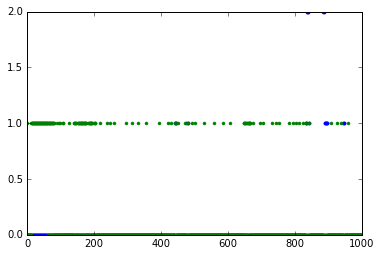

In [18]:
plt.plot(np.array([all_pred[-1].reshape(1000),targets_cat]).T,'.')

In [19]:
def get_point(s,start=0,end=63,height= 16):
    X = int(s*(end-start))
    if X < start:
        X = start
    if X > end:
        X = end
    return (X,height)
lines = [list(map(get_point,p)) for p in all_pred]
lines_t = [list(map(get_point,targets_cat))]
%matplotlib

Using matplotlib backend: MacOSX


In [20]:
from PIL import Image, ImageDraw
import matplotlib.animation as animation
for datafile in dfiles[0:]:
    with h5py.File(datafile) as data:
        figure = plt.figure()
        imageplot = plt.imshow(np.zeros((64, 64, 3), dtype=np.uint8))
        
        def next_frame(i):
            im = Image.fromarray(np.array(imgs[i].transpose(1,2,0),dtype=np.uint8))
            draw = ImageDraw.Draw(im) 
            draw.line((21,48, 21,all_pred[-1][i]*48),
                        fill=(255,0,0,128))
            draw.line((42,48, 42,targets_cat[i]*48),
                        fill=(0,255,0,128))
            imageplot.set_array(im)
            return imageplot,
        animate = animation.FuncAnimation(figure, next_frame, frames=range(len(imgs)), interval=100, blit=False)
        plt.show()

In [21]:
plt.plot(np.array([all_pred[-1].reshape(1000),targets_cat]).T)

In [ ]:
#animate.save('/Users/davidleifer/Desktop/DanDoesData/self-driving/animation.gif', writer='imagemagick', fps=30)

In [22]:
plt.plot(np.array([all_pred[-1].reshape(1000),targets_cat]).T,'.')

In [23]:
%matplotlib inline

In [24]:
h

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]], dtype=float32)

In [25]:
np.argmax(h)

0

In [26]:
targets_cat

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,


In [27]:
all_pred

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,